In [1]:
!pip install -q stellargraph[demos]==1.2.1

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.19.5 which is incompatible.
tfx-bsl 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tens

# Node classification on Cora dataset using Graph Attention Networks

In [2]:
import stellargraph as sg
import sys
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

2022-09-03 18:19:42.476831: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
import networkx as nx
import pandas as pd
import os
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt

In [4]:
data = datasets.Cora()
display(HTML(data.description))
graph , nodes = data.load()
print(nodes)

31336             Neural_Networks
1061127             Rule_Learning
1106406    Reinforcement_Learning
13195      Reinforcement_Learning
37879       Probabilistic_Methods
                    ...          
1128975        Genetic_Algorithms
1128977        Genetic_Algorithms
1128978        Genetic_Algorithms
117328                 Case_Based
24043             Neural_Networks
Name: subject, Length: 2708, dtype: object


In [5]:
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


>**Graph contains all the info about the graph which inlcludes no. of nodes,edges and feature vectors of the nodes**
>**The feature vactor is basically words which describe it. Here each is 1433 dimension vector**
>**Here all the nodes either belong to either of the three classes**

In [6]:
pd.Series.value_counts(nodes)

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64

* ***The names are basically the class names***

In [7]:
train,test = model_selection.train_test_split(nodes,train_size=140,test_size = None,stratify = nodes)
val,test = model_selection.train_test_split(test,train_size=500,test_size = None,stratify = test)

* ***Here we are splitting the total nodes into training, validation and testing sets***
* ***This is tranductive learning which just means there can be nodes of the graph in the testing or validation sets which might be connected to nodes in the training set***
* ***Note: we are using stratify as the range of spread of the nodes of various class is uneven***

In [8]:
encoding = preprocessing.LabelBinarizer()
train_encoded = encoding.fit_transform(train)
val_encoded = encoding.transform(val)
test_encoded = encoding.transform(test)

* ***LableBinarizer basically converts the categorical data into one-hot encoded vectors of dimension of 7***
* ***Then we fit the training, validation and testing nodes to convert each of the nodes to 7 dimentions vectors***
* ***This is basically the class values in a one-hot vector***

In [9]:
print(train_encoded.shape)
print(val_encoded.shape,test_encoded.shape)

(140, 7)
(500, 7) (2068, 7)


In [10]:
gen = FullBatchNodeGenerator(graph,method="gat")
train_gen = gen.flow(train.index,train_encoded)
gat = GAT(
layer_sizes=[10,train_encoded.shape[1]],
activations=["LeakyReLU","softmax"],
attn_heads = 10,
generator = gen,
in_dropout = 0.5,
attn_dropout = 0.5,normalize = None)

> ***FullBatchNodeGenerator builds the graph structure which can be fed into the GNN which can be GCN or GAN, etc, specified by method attribute***
> ***The flow() performs the task of aggregating the nodal and edge-wise info to produce a model which can be trained and evaluated***
> ***Next we create the GAT class. It has a hidden layer with 10 nodes with LeakyReLU activaton function. The last layer is sigmoid activated with shape of (1, no. of nodes, 7)***

In [11]:
input_x , pred = gat.in_out_tensors()
val_gen = gen.flow(val.index,val_encoded)

In [12]:
model = Model(inputs = input_x,outputs = pred)
model.compile(optimizer=optimizers.Adam(learning_rate=0.005),metrics=["acc"],loss=losses.categorical_crossentropy)
train = model.fit(
train_gen,
epochs=80,
validation_data=val_gen,
verbose=2,
shuffle=False)

2022-09-03 18:19:44.919850: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/80
1/1 - 6s - loss: 1.9768 - acc: 0.1143 - val_loss: 1.8527 - val_acc: 0.3600
Epoch 2/80
1/1 - 0s - loss: 1.8665 - acc: 0.2786 - val_loss: 1.7691 - val_acc: 0.3520
Epoch 3/80
1/1 - 0s - loss: 1.7540 - acc: 0.3857 - val_loss: 1.6951 - val_acc: 0.3460
Epoch 4/80
1/1 - 0s - loss: 1.7042 - acc: 0.3857 - val_loss: 1.6279 - val_acc: 0.3540
Epoch 5/80
1/1 - 0s - loss: 1.6120 - acc: 0.4000 - val_loss: 1.5658 - val_acc: 0.3800
Epoch 6/80
1/1 - 0s - loss: 1.4569 - acc: 0.5000 - val_loss: 1.5050 - val_acc: 0.4100
Epoch 7/80
1/1 - 0s - loss: 1.4454 - acc: 0.5000 - val_loss: 1.4445 - val_acc: 0.4480
Epoch 8/80
1/1 - 0s - loss: 1.3075 - acc: 0.5214 - val_loss: 1.3834 - val_acc: 0.4840
Epoch 9/80
1/1 - 0s - loss: 1.2747 - acc: 0.5714 - val_loss: 1.3208 - val_acc: 0.5440
Epoch 10/80
1/1 - 0s - loss: 1.2848 - acc: 0.5929 - val_loss: 1.2583 - val_acc: 0.6380
Epoch 11/80
1/1 - 0s - loss: 1.1825 - acc: 0.6786 - val_loss: 1.1979 - val_acc: 0.7300
Epoch 12/80
1/1 - 0s - loss: 1.0488 - acc: 0.7143 - 

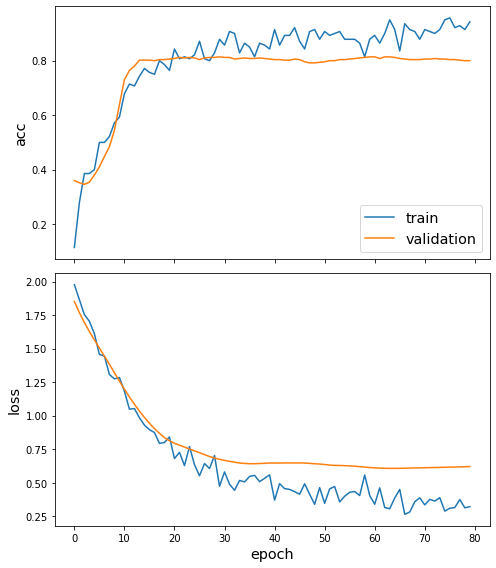

In [13]:
sg.utils.plot_history(train)

In [14]:
test_data = gen.flow(test.index,test_encoded)
evaluate = model.evaluate(test_data)
print(evaluate)

1/1 [==============================] - 0s 82ms/step - loss: 0.6263 - acc: 0.8119
[0.6262960433959961, 0.8118955492973328]


# ***Prediction for all the nodes***

In [15]:
all_data = gen.flow(nodes.index)
all_pred = model.predict(all_data)

In [16]:
test_pred = encoding.inverse_transform(all_pred.squeeze())
dataframe = pd.DataFrame({'Predicted':test_pred,"True":nodes})
dataframe.head(40)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Reinforcement_Learning,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory
